# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
%%time
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')

<string>:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 37.5 s, sys: 21.4 s, total: 58.9 s
Wall time: 4min 34s


In [13]:
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


**Load the first excel sheet with information about attributes. Create a dictionary to store the translations of these attributes.**

In [14]:
azdias_attr = pd.read_excel('DIAS Attributes - Values 2017.xlsx').drop('Unnamed: 0',axis=1)
azdias_attr.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly


In [15]:
# get translations
azdias_attr['Attribute'] = azdias_attr.Attribute.fillna(method='ffill')
azdias_attr['Description'] = azdias_attr.Description.fillna(method='ffill')
azdias_attr_grouped = pd.DataFrame(azdias_attr).groupby(by=['Attribute','Description']).count().reset_index().drop(['Meaning'], axis=1)
azdias_attr_grouped.head()

,Attribute,Description,Value
0,AGER_TYP,best-ager typology,5
1,ALTERSKATEGORIE_GROB,age classification through prename analysis,6
2,ALTER_HH,main age within the household,22
3,ANREDE_KZ,gender,3
4,ANZ_HAUSHALTE_AKTIV,number of households in the building,1


In [16]:
# get codes for missing data
azdias_attr_nan = azdias_attr.groupby('Attribute').nth(0).reset_index()

In [17]:
# these are already encoded with nan
feat_dismiss = ['ANZ_HAUSHALTE_AKTIV','ANZ_HH_TITEL','ANZ_PERSONEN','ANZ_TITEL','CAMEO_DEU_2015',
'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP','D19_VERSAND_ONLINE_QUOTE_12',
'GEBAEUDETYP_RASTER', 'GEBURTSJAHR','GFK_URLAUBERTYP','GREEN_AVANTGARDE','KBA13_ANZAHL_PKW',
'KONSUMNAEHE','LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB','LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB',
'LP_STATUS_FEIN','LP_STATUS_GROB', 'MIN_GEBAEUDEJAHR','PLZ8_BAUMAX', 'MOBI_REGIO']
# the NaN in here are represented by the value 10
feat_replace_10 = ['D19_BANKEN_DATUM','D19_BANKEN_ONLINE_DATUM','D19_GESAMT_DATUM','D19_GESAMT_OFFLINE_DATUM',
                   'D19_GESAMT_ONLINE_DATUM','D19_TELKO_DATUM','D19_TELKO_OFFLINE_DATUM','D19_TELKO_ONLINE_DATUM',
                   'D19_VERSAND_DATUM','D19_VERSAND_OFFLINE_DATUM','D19_VERSAND_ONLINE_DATUM']
def encode_nan(row):
    '''
    replace missings values according to excel spreadsheet
    '''
    if row[0] in feat_replace_10:
        row[3] = [10]
    elif row[0] in feat_dismiss:
        row[3] = []
    else:
        # we got the right nan encoding, just make it a list
        l = str(row[3]).split(',')
        row[3] = [int(s) for s in l] 
        
    return row

azdias_attr_nan = azdias_attr_nan.apply(lambda x: encode_nan(x), axis=1)
azdias_attr_nan.head()

,Attribute,Description,Meaning,Value
0,AGER_TYP,best-ager typology,unknown,[-1]
1,ALTERSKATEGORIE_GROB,age classification through prename analysis,unknown,"[-1, 0]"
2,ALTER_HH,main age within the household,unknown / no main age detectable,[0]
3,ANREDE_KZ,gender,unknown,"[-1, 0]"
4,ANZ_HAUSHALTE_AKTIV,number of households in the building,numeric value (typically coded from 1-10),[]


**Loads the second excel scheet with additional information about the attributes.**


In [18]:
azdias_levels = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx').drop('Unnamed: 0', axis=1)
azdias_levels.head()

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


In [19]:
# fill the first missing value to use ffill in next cell
azdias_levels.iloc[0]['Information level'] = 'Person'
azdias_levels['Information level'] = azdias_levels['Information level'].fillna(method='ffill')

# create dict to store translations
azdias_translations_lvl = dict()

def add_to_dict_lvl(key, value):
    '''
    populate dictionary with feature as keys and feature translation as value
    '''
    azdias_translations_lvl[key] = value
    
azdias_levels.apply(lambda x: add_to_dict_lvl(x[1], x[2]), axis=1);
azdias_translations_lvl

{'AGER_TYP': 'best-ager typology',
 'ALTERSKATEGORIE_GROB': 'age through prename analysis ',
 'ANREDE_KZ': 'gender',
 'CJT_GESAMTTYP': 'Customer-Journey-Typology relating to the preferred information and buying channels of consumers',
 'FINANZ_MINIMALIST': 'financial typology: low financial interest',
 'FINANZ_SPARER': 'financial typology: money saver',
 'FINANZ_VORSORGER': 'financial typology: be prepared',
 'FINANZ_ANLEGER': 'financial typology: investor',
 'FINANZ_UNAUFFAELLIGER': 'financial typology: unremarkable',
 'FINANZ_HAUSBAUER': 'financial typology: main focus is the own house',
 'FINANZTYP': 'best descirbing financial type for the peron',
 'GEBURTSJAHR': 'year of birth',
 'GFK_URLAUBERTYP': 'vacation habits',
 'GREEN_AVANTGARDE': 'the environmental sustainability is the dominating movement in the youth of these consumers',
 'HEALTH_TYP': 'health typology',
 'LP_LEBENSPHASE_FEIN': 'lifestage fine',
 'LP_LEBENSPHASE_GROB': 'lifestage rough',
 'LP_FAMILIE_FEIN': 'family type f

In [20]:
# store dataframe taht will be used later as pickles
pickle.dump(azdias_attr_nan, open("azdias_attr_nan.pickle", "wb"))

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [21]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [22]:
azdias.dtypes.value_counts()

float64    267
int64       93
object       6
dtype: int64

In [3]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


### Assess missing data


- Replace missing data encoded values according to azdias_attr_nan:

In [23]:
azdias_attr_nan.head()

,Attribute,Description,Meaning,Value
0,AGER_TYP,best-ager typology,unknown,[-1]
1,ALTERSKATEGORIE_GROB,age classification through prename analysis,unknown,"[-1, 0]"
2,ALTER_HH,main age within the household,unknown / no main age detectable,[0]
3,ANREDE_KZ,gender,unknown,"[-1, 0]"
4,ANZ_HAUSHALTE_AKTIV,number of households in the building,numeric value (typically coded from 1-10),[]


In [24]:
azdias_mapped = azdias.copy()
all_features = azdias_attr_nan['Attribute']
features = [feat for feat in all_features if feat in azdias.columns]

for feature in features:
    # get list of values to encode as NaN
    s = azdias_attr_nan[azdias_attr_nan['Attribute'] == feature]['Value'].values[0]
    n = len(s)
    
    if n:
        if s[0]: # if there is missing_or_unknown values to replace, do it
            if(azdias_mapped.dtypes[feature] == 'object'):
                d = {n: np.nan for n in list(map(lambda x: str(x), s))}
            else:
                d = {n: np.nan for n in list(map(lambda x: int(x), s))}

            azdias_mapped[feature] = azdias_mapped[feature].replace(d)

**Missing data per Column**

In [25]:
%%time
na_counts = azdias_mapped.isnull().sum()

CPU times: user 8.35 s, sys: 13.3 s, total: 21.7 s
Wall time: 2min 29s


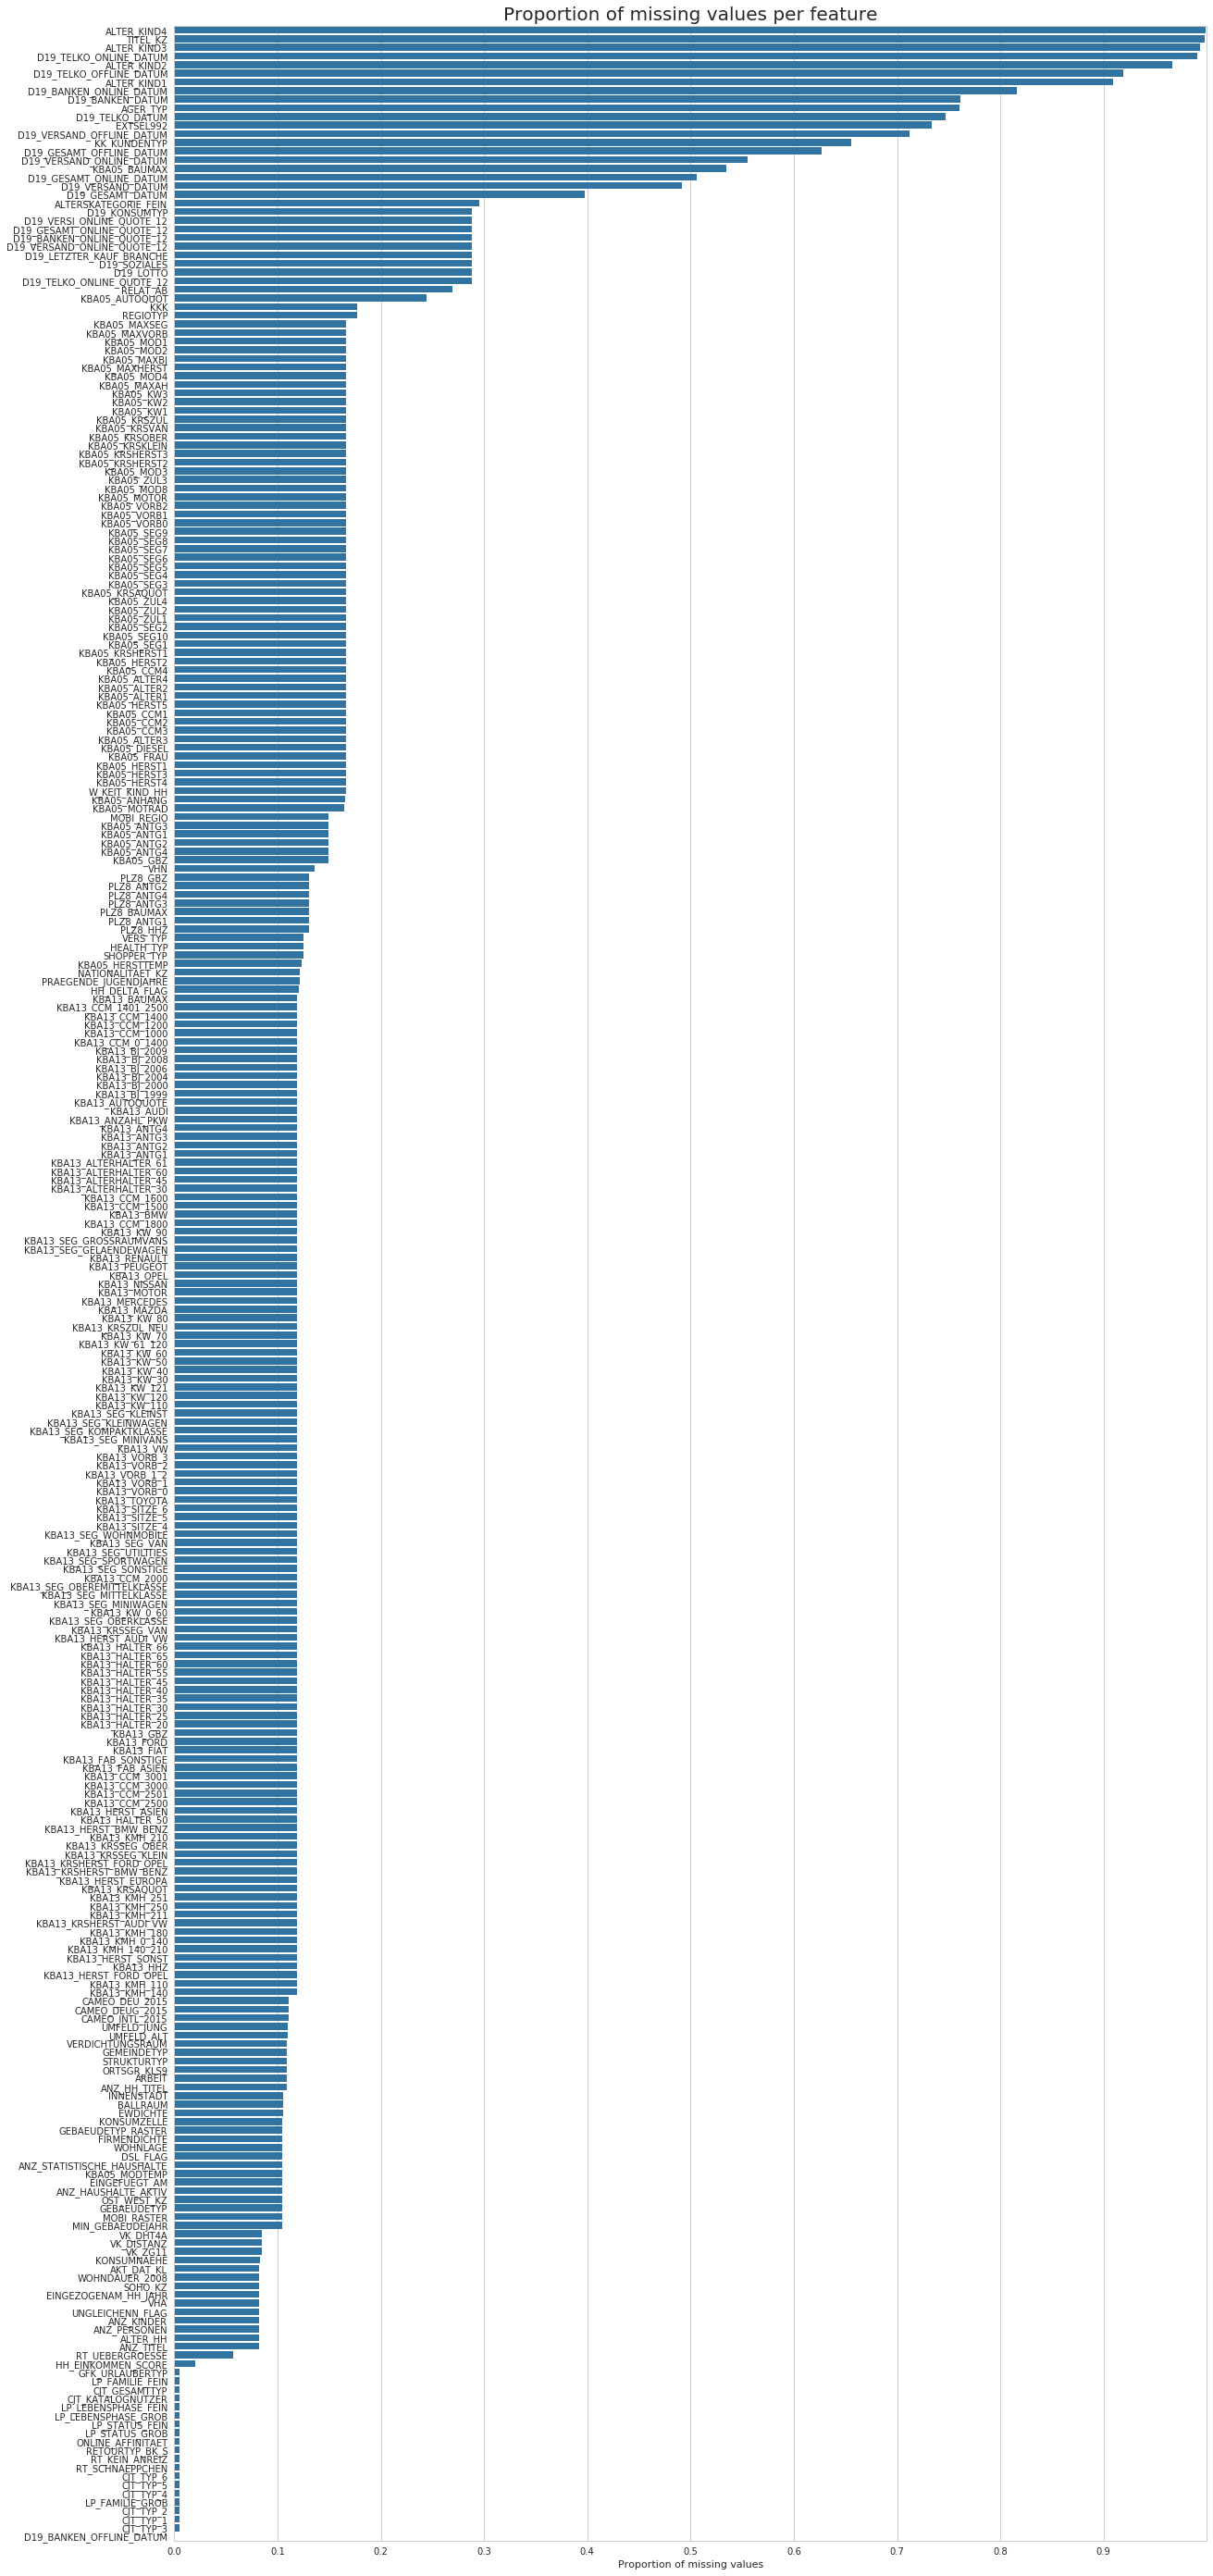

In [26]:
# plot columns that have missing values
base_color = sns.color_palette()[0]
na_counts_subset = na_counts[na_counts != 0]
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(20, 50))
na_counts_subset = na_counts_subset.sort_values(ascending=False)
x_values = na_counts_subset / azdias.shape[0]
g = sns.barplot(x=x_values, y=na_counts_subset.index, color=base_color)

plt.xticks(np.arange(0, 1, 0.1))
plt.title('Proportion of missing values per feature',fontdict={'fontsize': 20});
ax.set(xlim=(0, 1), xlabel="Proportion of missing values");

In [27]:
outliers_features = na_counts_subset/azdias.shape[0]
outliers_features = outliers_features[outliers_features > 0.3].index

In [28]:
outliers_features

Index(['ALTER_KIND4', 'TITEL_KZ', 'ALTER_KIND3', 'D19_TELKO_ONLINE_DATUM',
       'ALTER_KIND2', 'D19_TELKO_OFFLINE_DATUM', 'ALTER_KIND1',
       'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_DATUM', 'AGER_TYP',
       'D19_TELKO_DATUM', 'EXTSEL992', 'D19_VERSAND_OFFLINE_DATUM',
       'KK_KUNDENTYP', 'D19_GESAMT_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM',
       'KBA05_BAUMAX', 'D19_GESAMT_ONLINE_DATUM', 'D19_VERSAND_DATUM',
       'D19_GESAMT_DATUM'],
      dtype='object')

In [29]:
# print size of dataset before dropping outlier features
print(azdias_mapped.shape)

(891221, 366)


In [30]:
# dropping outliers features
azdias_mapped.drop(labels=outliers_features, axis=1, inplace=True)

In [31]:
azdias_mapped.shape

(891221, 346)

**Discussion: Dropping missing Data in Columns**

Seems like some of these features were note contained in the excel file. The remaining were related to Academic Title, Age, Building-type and Actuality of transactions.

### Assessing missing data in each row

In [32]:
na_rows = azdias_mapped.isnull().sum(axis=1)
na_rows[:10]

0    249
1     10
2      0
3      4
4      0
5      0
6      1
7      0
8      9
9      1
dtype: int64

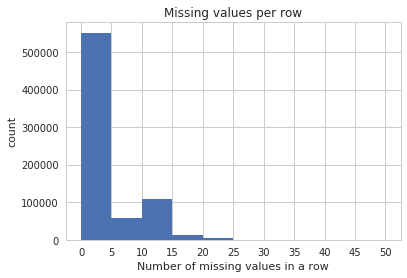

In [33]:
bins = np.arange(0, 47+5, 5);
plt.hist(na_rows, bins=bins);
plt.xticks(np.arange(0,47+5,5));
plt.xlabel('Number of missing values in a row')
plt.ylabel('count');
plt.title('Missing values per row');

In [34]:
#30min from here

In [37]:
%%time
# divide the data into two subsets based on the number of missing values in each row.
threshold = 20
subset_above = azdias_mapped[na_rows > threshold]
subset_below = azdias_mapped[na_rows <= threshold]
print("Below percentage of dataset {:0.2%}".format(subset_below.shape[0]/azdias.shape[0]))
print("Above percentage of dataset {:0.2%}".format(subset_above.shape[0]/azdias.shape[0]))

Below percentage of dataset 82.35%
Above percentage of dataset 17.65%
CPU times: user 2.16 s, sys: 4.74 s, total: 6.91 s
Wall time: 1min 12s


In [38]:
%%time
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# find columns which have 0 values missing
below_count = subset_below.isnull().sum()
features = subset_below.columns[below_count==0]
features

CPU times: user 4.8 s, sys: 1.94 s, total: 6.74 s
Wall time: 34.5 s


**Plot the distributions of features in subset below and above threshold**
    - The distributions of non-missing features look similar between the data with many missing values(subset_above) and the data with few or no missing values(subset_below), then dropping those points from the analysis won't present a major issue.

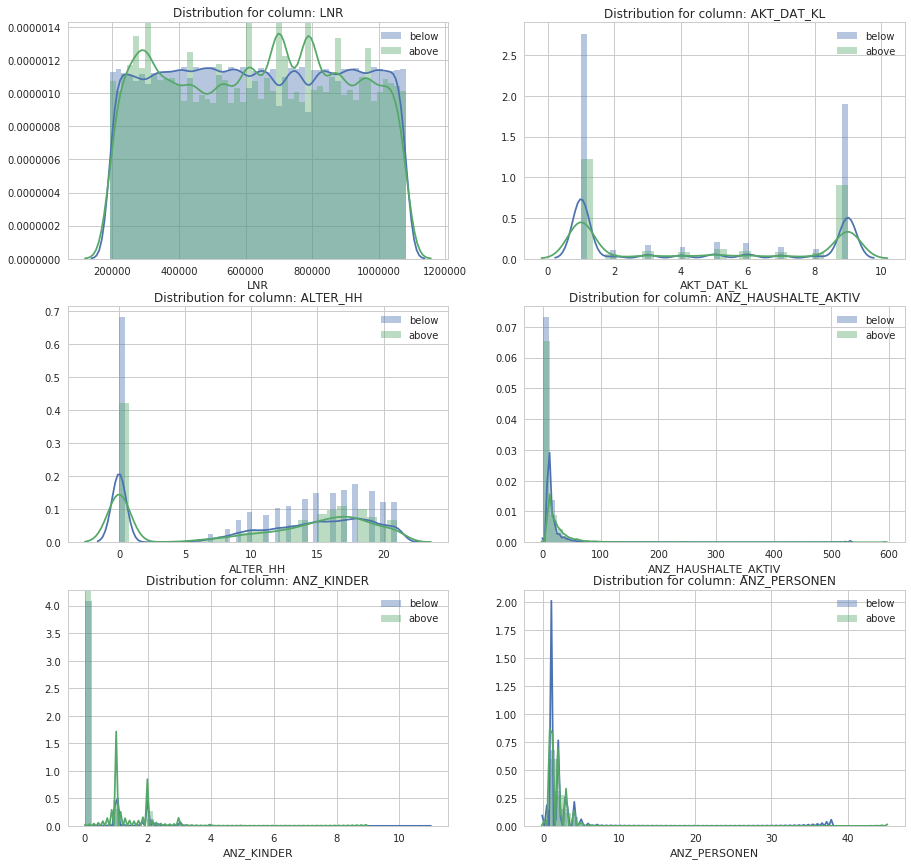

In [39]:
plt.figure(figsize=(15,20))
for i, col in enumerate(features[:6]):
    plt.subplot(4, 2, i+1)
    sns.distplot(subset_below[col].dropna(), label='below')
    sns.distplot(subset_above[col].dropna(), label='above')
    plt.title('Distribution for column: {}'.format(col))
    plt.legend();

### Select and Re-encode Features

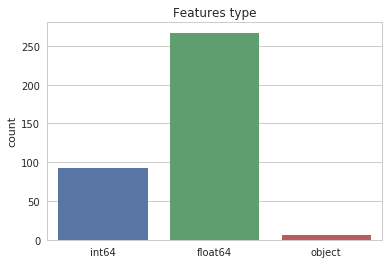

In [40]:
g = sns.countplot(x=azdias.dtypes);
g.set_title('Features type');

In [41]:
float_features = azdias.dtypes[azdias.dtypes=='float64'].index
object_features = azdias.dtypes[azdias.dtypes=='object'].index
int_features = azdias.dtypes[azdias.dtypes=='int64'].index

### Re-encoding object features

In [42]:
object_features

Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ'],
      dtype='object')

In [43]:
# Reencode binary variable which have non-numeric value
subset_below['OST_WEST_KZ'] = subset_below['OST_WEST_KZ'].map({'W': 0, 'O': 1})

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


**Feature: EINGEFUEGT_AM**
    - timestamp, map to year and Label Encode it

In [44]:
# map feature to year
subset_below['EINGEFUEGT_AM'] = subset_below['EINGEFUEGT_AM'].str.split().map(lambda x: x[0][:4])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [45]:
# encode year as integers
encoded_feature, _ = pd.factorize(subset_below['EINGEFUEGT_AM'])
subset_below['EINGEFUEGT_AM'] = encoded_feature

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


**Feature: D19_LETZTER_KAUF_BRANCHE**

    - 178370 UNBEKANNT(UNKNOWN) + 163146 NaN ==> drop feature

In [46]:
# check count of NaN
subset_below['D19_LETZTER_KAUF_BRANCHE'].isnull().sum()

163146

In [47]:
# check levels of feature
subset_below['D19_LETZTER_KAUF_BRANCHE'].str.split('_').map(lambda x: x[1] if x is not np.nan else x).value_counts()

UNBEKANNT             178370
VERSICHERUNGEN         51994
SONSTIGE               40377
BANKEN                 36387
VOLLSORTIMENT          31174
SCHUHE                 28383
BEKLEIDUNG             28193
BUCH                   25541
TELKO                  23505
VERSAND                23310
DROGERIEARTIKEL        21290
HAUS                   18743
ENERGIE                11098
KINDERARTIKEL           6389
FREIZEIT                6370
TECHNIK                 6255
LEBENSMITTEL            5786
RATGEBER                4467
NAHRUNGSERGAENZUNG      3712
DIGIT                   3258
REISEN                  2796
TIERARTIKEL             2290
SAMMELARTIKEL           2236
HANDWERK                2023
WEIN                    1960
GARTEN                  1482
BIO                     1082
BILDUNG                  873
LOTTO                    740
KOSMETIK                 709
Name: D19_LETZTER_KAUF_BRANCHE, dtype: int64

In [48]:
subset_above['D19_LETZTER_KAUF_BRANCHE'].value_counts()

D19_UNBEKANNT             16968
D19_VERSICHERUNGEN         5740
D19_SONSTIGE               4345
D19_SCHUHE                 4195
D19_VOLLSORTIMENT          3638
D19_BUCH_CD                3213
D19_DROGERIEARTIKEL        2782
D19_BEKLEIDUNG_REST        2728
D19_VERSAND_REST           2724
D19_BANKEN_DIREKT          2383
D19_HAUS_DEKO              2115
D19_TELKO_MOBILE           1337
D19_BEKLEIDUNG_GEH         1147
D19_TELKO_REST             1077
D19_BANKEN_GROSS           1037
D19_ENERGIE                 986
D19_KINDERARTIKEL           912
D19_FREIZEIT                887
D19_TECHNIK                 747
D19_LEBENSMITTEL            672
D19_BANKEN_REST             561
D19_RATGEBER                464
D19_NAHRUNGSERGAENZUNG      349
D19_REISEN                  326
D19_DIGIT_SERV              319
D19_TIERARTIKEL             288
D19_SAMMELARTIKEL           207
D19_WEIN_FEINKOST           204
D19_HANDWERK                204
D19_GARTEN                  164
D19_BIO_OEKO                150
D19_BANK

In [49]:
%%time
subset_below = subset_below.drop(labels=['D19_LETZTER_KAUF_BRANCHE'], axis=1)

CPU times: user 1.19 s, sys: 11.2 s, total: 12.4 s
Wall time: 1min 27s


#### Features: 'CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015'
    - map CAME_INTL_2015 into 2 new variables about wealth and life_stage
    - drop CAMEO_DEUG_2015

In [50]:
#original_cameo_int = subset_below['CAMEO_INTL_2015']

In [51]:
# convert column to be float (some values are string) 
subset_below['CAMEO_INTL_2015'] = subset_below['CAMEO_INTL_2015'].replace({'XX': np.nan})
subset_below['CAMEO_INTL_2015'] = subset_below['CAMEO_INTL_2015'].apply(lambda x: float(x))

In [52]:
def map_wealth(val):
    if not np.isnan(val):
        return int(val)//10
    else:
        return val

def map_life_stage(val):
    
    if not np.isnan(val):
        return int(val)%10
    else:
        return val

subset_below['CAMEO_INTL_2015_WEALTH'] = subset_below['CAMEO_INTL_2015'].map(map_wealth)
subset_below['CAMEO_INTL_2015_LIFE_STAGE'] = subset_below['CAMEO_INTL_2015'].map(map_life_stage)

In [53]:
# drop CAMEO_DEUG_2015
subset_below = subset_below.drop(labels=['CAMEO_DEUG_2015'], axis=1)

In [54]:
# map CAMEO_DEU_2015 to new feature keeping the first int
# 2A --> 2
subset_below['CAMEO_DEU_2015'] = subset_below['CAMEO_DEU_2015'].replace({'XX': np.nan})
subset_below['CAMEO_DEU_2015'] = subset_below['CAMEO_DEU_2015'].map(lambda x: int(x[0]) if x is not np.nan else x)                   

### Create a cleaning function

In [31]:
def replace_nan(dataframe, azdias_attr_nan):
    '''
    for each feature in dataframe, replaces values encoded in azdias_attr_nan with np.nan
    '''
    
    all_features = azdias_attr_nan['Attribute']
    features = [feat for feat in all_features if feat in dataframe.columns]

    for feature in features:
        # get missing_or_unknown for current feature and put in a list
        missing_str = azdias_attr_nan[azdias_attr_nan['Attribute'] == feature]['Value']
        s = missing_str.values[0]
        n = len(s)
        if n:
            if s[0]: # if there is missing_or_unknown values to replace, do it
                if(dataframe.dtypes[feature] == 'object'):
                    d = {n: np.nan for n in list(map(lambda x: str(x), s))}
                else:
                    d = {n: np.nan for n in list(map(lambda x: int(x), s))}

                dataframe[feature] = dataframe[feature].replace(d)
    return dataframe

def remove_outliers(dataframe):
    '''
    drop outliers columns in dataframe
    '''
    outliers_features = ['ALTER_KIND4', 'TITEL_KZ', 'ALTER_KIND3', 'D19_TELKO_ONLINE_DATUM',
       'ALTER_KIND2', 'D19_TELKO_OFFLINE_DATUM', 'ALTER_KIND1',
       'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_DATUM', 'AGER_TYP',
       'D19_TELKO_DATUM', 'EXTSEL992', 'D19_VERSAND_OFFLINE_DATUM',
       'KK_KUNDENTYP', 'D19_GESAMT_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM',
       'KBA05_BAUMAX', 'D19_GESAMT_ONLINE_DATUM', 'D19_VERSAND_DATUM',
       'D19_GESAMT_DATUM']

    dataframe.drop(labels=outliers_features, axis=1, inplace=True)
    return dataframe

def select_subset(dataframe):
    '''
    remove from dataframe rows with more than 20 missing values
    '''
    threshold = 20
    return dataframe[dataframe.isnull().sum(axis=1) <= threshold]

def map_wealth(val):
    '''
    map values of the feature CAMEO_INTL_2015 to get wealth part
    '''
    if not np.isnan(val):
        return int(val)//10
    else:
        return val

def map_life_stage(val):
    '''
    map value of the feature to get life stage part
    '''
    
    if not np.isnan(val):
        return int(val)%10
    else:
        return val
    
def preprocessing_categorical(dataframe):
    '''
    transform object features in dataframe to numerical
    '''
    
    dataframe['OST_WEST_KZ'] = dataframe['OST_WEST_KZ'].map({'W': 0, 'O': 1})

    # D19_LETZTER_KAUF_BRANCHE
    # drop

    # CAMEO_INTL_2015
    dataframe['CAMEO_INTL_2015'] = dataframe['CAMEO_INTL_2015'].replace({'XX': np.nan})
    dataframe['CAMEO_INTL_2015'] = dataframe['CAMEO_INTL_2015'].apply(lambda x: float(x))

    # CAMEO_INTL_2015
    dataframe['CAMEO_INTL_2015_WEALTH'] = dataframe['CAMEO_INTL_2015'].map(map_wealth)
    dataframe['CAMEO_INTL_2015_LIFE_STAGE'] = dataframe['CAMEO_INTL_2015'].map(map_life_stage)

    #  CAMEO_DEUG_2015
    # drop

    #  CAMEO_DEU_2015 
    dataframe['CAMEO_DEU_2015'] = dataframe['CAMEO_DEU_2015'].replace({'XX': np.nan})
    dataframe['CAMEO_DEU_2015'] = dataframe['CAMEO_DEU_2015'].map(lambda x: int(x[0]) if x is not np.nan else x)    

    drop_features = ['D19_LETZTER_KAUF_BRANCHE', 'CAMEO_DEUG_2015', 'EINGEFUEGT_AM']

    dataframe.drop(labels=drop_features, axis=1, inplace=True)
    return dataframe

def clean_data(dataframe, azdias_attr_nan):
    '''
    clean dataframe pipeline
    '''
    x = replace_nan(dataframe, azdias_attr_nan)
    x = remove_outliers(x)
    x = select_subset(x)
    x = preprocessing_categorical(x)
    return x

### Clean data for general population and customers

In [3]:
# Load general population data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
azdias_attr_nan = pickle.load(open("azdias_attr_nan.pickle", "rb"))

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Clean general population data
cleaned_data = clean_data(azdias, azdias_attr_nan)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

In [5]:
# Load and clean customers data
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')
azdias_attr_nan = pickle.load(open("azdias_attr_nan.pickle", "rb"))

customers = clean_data(customers, azdias_attr_nan)
customers.drop(labels=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:59: SettingWithCopyW

## Feature Scaling

#### Impute missing values
    - PCA does not handle missing values
    - replace with most frequent value

In [6]:
imputer = Imputer(missing_values=np.nan, strategy='most_frequent', axis=0)
X = imputer.fit_transform(cleaned_data)

# create a dataframe from X with the features names
X = pd.DataFrame(X)
X.columns = cleaned_data.columns

In [7]:
# do the same for customers
Xc = imputer.transform(customers)
Xc = pd.DataFrame(Xc)
Xc.columns = customers.columns

#### Apply feature scaling
    - Apply feature scaling to the general population demographics data.

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled)

In [9]:
# do the same for customers
Xc_scaled = scaler.transform(Xc)
Xc_scaled = pd.DataFrame(Xc_scaled)

In [13]:
pickle.dump(X_scaled, open("X_scaled.pickle", "wb"))
pickle.dump(Xc_scaled, open("Xc_scaled.pickle", "wb"))

### Perform Dimensionality Reduction
    - Apply PCA on the data, thus finding the vectors of maximal variance in the data.
    - First does not set any parameters so there's enough features to see the general trend in variability
    - select a value for the number of transformed features retained for the clustering.
    - Re-fit a PCA to perform on the new number of features retained.

In [14]:
# First try PCA with all features in the general population data.
pca = PCA()
X_pca = pca.fit_transform(X_scaled)
X_pca.shape

(733939, 345)

In [15]:
def scree_plot(pca):
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
    ax.set_yticks(np.arange(0,1+0.1,0.1))
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

In [16]:
# first 5 components explained variance
print("Amount of explained variance by the first 5 principal components: {0}".format(pca.explained_variance_ratio_[:5].sum()))
print("Amount of explained variance by the first 50 principal components: {0}".format(pca.explained_variance_ratio_[:50].sum()))
print("Amount of explained variance by the first 150 principal components: {0}".format(pca.explained_variance_ratio_[:150].sum()))
print("Amount of explained variance by the first 200 principal components: {0}".format(pca.explained_variance_ratio_[:200].sum()))

Amount of explained variance by the first 5 principal components: 0.24849587787510333
Amount of explained variance by the first 50 principal components: 0.6017885413712193
Amount of explained variance by the first 150 principal components: 0.8596851934113097
Amount of explained variance by the first 200 principal components: 0.9310375716835952


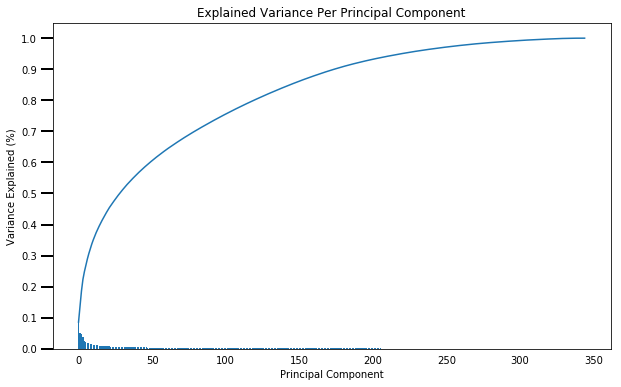

In [17]:
# Investigate the variance accounted for by each principal component.
scree_plot(pca)

So now we re-fit PCA with 150 components:

In [18]:
# Apply PCA to the general population
pca = PCA(n_components=150)
X_pca = pca.fit_transform(X_scaled)
X_pca.shape

(733939, 150)

In [19]:
# Apply PCA to customers
Xc_pca = pca.transform(Xc_scaled)
Xc_pca.shape

(132345, 150)

In [20]:
feat_names = X.columns
def pca_weight(pca, n):
    d = {}
    for i, f in enumerate(feat_names):
        d[f] = pca.components_[n][i]
    return sorted(d.items(), key=lambda kv: kv[1], reverse=True)

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

In [21]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
d = pca_weight(pca, 0)
d

[('MOBI_REGIO', 0.14260137419078309),
 ('PLZ8_ANTG1', 0.1370395817179495),
 ('KBA13_ANTG1', 0.13636024719963227),
 ('LP_STATUS_FEIN', 0.13286273736073143),
 ('KBA05_ANTG1', 0.13250075893861832),
 ('LP_STATUS_GROB', 0.13061694569358279),
 ('MOBI_RASTER', 0.12959117608683438),
 ('KBA05_GBZ', 0.12504987248366745),
 ('KBA13_AUTOQUOTE', 0.12206718195259895),
 ('KBA05_AUTOQUOT', 0.11258733311614376),
 ('FINANZ_MINIMALIST', 0.11217113253083617),
 ('GEMEINDETYP', 0.10426233429080418),
 ('LP_LEBENSPHASE_FEIN', 0.10260489968863158),
 ('KBA13_GBZ', 0.10244891272230996),
 ('PLZ8_GBZ', 0.10156472534333243),
 ('KBA05_ANHANG', 0.099303375686932066),
 ('KBA13_ALTERHALTER_60', 0.095319457053171075),
 ('KONSUMNAEHE', 0.094961702024585815),
 ('LP_LEBENSPHASE_GROB', 0.094742480815681013),
 ('KBA13_HALTER_55', 0.091155644981324335),
 ('INNENSTADT', 0.090465673292588589),
 ('KBA05_KRSAQUOT', 0.085573594678070769),
 ('KBA13_HALTER_50', 0.085219419923582812),
 ('FIRMENDICHTE', 0.078834759105327293),
 ('KBA13_

In [22]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
d = pca_weight(pca, 1)
d

[('KBA13_HERST_BMW_BENZ', 0.1832863922785474),
 ('KBA13_MERCEDES', 0.15738622619025799),
 ('KBA13_SEG_OBEREMITTELKLASSE', 0.15687651904608449),
 ('KBA13_BMW', 0.15223472995336959),
 ('KBA13_SITZE_4', 0.14631610694156827),
 ('KBA13_SEG_SPORTWAGEN', 0.14133919820586313),
 ('KBA05_HERST1', 0.12916563370379802),
 ('KBA13_KMH_211', 0.1276923047716885),
 ('KBA13_KMH_250', 0.1254367084449298),
 ('KBA13_KW_121', 0.12458271898350246),
 ('KBA13_SEG_OBERKLASSE', 0.12182898890470539),
 ('KBA13_CCM_2501', 0.11909435823674337),
 ('KBA05_KW3', 0.11861488638810555),
 ('KBA13_CCM_3000', 0.11087640523070681),
 ('KBA05_MOTOR', 0.11007220603820361),
 ('KBA13_KRSHERST_BMW_BENZ', 0.10993333489299643),
 ('KBA13_CCM_3001', 0.10640281148043755),
 ('KBA05_MOD1', 0.10560849537137254),
 ('KBA05_CCM4', 0.10430779748717486),
 ('KBA13_HALTER_65', 0.10105829514577296),
 ('KBA05_SEG5', 0.095658410578616793),
 ('EWDICHTE', 0.093719382919349309),
 ('STRUKTURTYP', 0.088952993003766814),
 ('KBA13_CCM_2500', 0.088322068186

In [23]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
d = pca_weight(pca, 2)
d

[('PRAEGENDE_JUGENDJAHRE', 0.18759278916809458),
 ('CJT_TYP_2', 0.18295771256708976),
 ('CJT_TYP_1', 0.18220407549481796),
 ('FINANZ_SPARER', 0.17553980386577303),
 ('ONLINE_AFFINITAET', 0.16977647871718585),
 ('FINANZ_UNAUFFAELLIGER', 0.15387641096469773),
 ('SEMIO_PFLICHT', 0.15153591555915444),
 ('ALTERSKATEGORIE_FEIN', 0.14989715646379159),
 ('SEMIO_TRADV', 0.14543648002938186),
 ('FINANZ_ANLEGER', 0.13783327640727641),
 ('SEMIO_RAT', 0.13465097517597693),
 ('SEMIO_REL', 0.13408113388377599),
 ('D19_GESAMT_ANZ_24', 0.12936685867498007),
 ('D19_GESAMT_ANZ_12', 0.12062310871209266),
 ('D19_VERSAND_ANZ_24', 0.11803418060666532),
 ('RT_UEBERGROESSE', 0.1146489928606588),
 ('D19_GESAMT_ONLINE_QUOTE_12', 0.11161687423146235),
 ('RT_KEIN_ANREIZ', 0.11105696607573258),
 ('D19_VERSAND_ONLINE_QUOTE_12', 0.10902629505724243),
 ('D19_VERSAND_ANZ_12', 0.10763640163093874),
 ('CJT_GESAMTTYP', 0.10469061217916037),
 ('ALTER_HH', 0.10376350978194059),
 ('D19_VERSAND_REST', 0.090757048936764548),
 

## Interpretation on Principal Components

**1. First principal component**

**Positive weight features** 

| Feature        | Meaning           | Weight  |
| ------------- |:-------------:| -----:|
| MOBI_REGIO | movement pattern | 0.1426|
| PLZ8_ANTG1 | number of 1-2 family houses in the PLZ8|0.1370|
| KBA13_ANTG1| number of 1-2 family houses in the cell      |   0.1363 |
| KBA05_ANTG1| number of 1-2 family houses in the cell      |    1 |
| LP_STATUS_FEIN | social status fine      |   0.1328|
| LP_STATUS_GROB |social status rough     |    0.1306 |
| KBA05_GBZ | number of buildings in the microcell|    0.1250 |
| KBA13_AUTOQUOTE | share of cars per household within the PLZ8   |    0.1125 |


* The first principal component is positively correlated with features regarding: high social status and lower size families which have cars.
    - houseowners, top-earners [LP_STATUS_GROB, LP_STATUS_FEIN ]
    - small families in the area (1-2 family houses) [KBA05_ANTG1, KBA13_ANTG1, PLZ8_ANTG1]
    - car ownership (high share of cars)
    - urban areas (areas with higher quantity of buildings)
    


**Negative weights**: the decrease of these features means an increase on the component (negative correlation)

| Feature        | Meaning           | Weight  |
| ------------- | -------------| -----|
| EWDICHTE | density of inhabitants per square kilometer | -0.1093|
| CAMEO_INTL_2015 | wealth indicator (lower means more wealth)|-0.1273|
| HH_EINKOMMEN_SCORE| house income (higher means lower income)     |   -0.1280 |
|CAMEO_INTL_2015_WEALTH| wealth indicator| -0.1293 |
| PLZ8_BAUMAX| nbuilding-type within the PLZ8(lower means mainly 1-2 family homes) |   -0.1286 |
| PLZ8_ANTG4 |  number of >10 family houses in the PLZ8 (decrease means smaller families)     |   -0.1298|
| KBA13_BAUMAX | most common building-type within the cell     |    -0.1302|


* This component increase with the decrease of features (negative correlated):

    - wealth families [low value of HH_EINKOMMEN_SCORE and CAMEO_INTL_2015_WEALTH]
    - smaller families  [low value of PLZ8_ANTG4]

So the interpretation of this is the same as the positive weight features. 

**Conclusion:** This suggests that this first feature is about wealthy and smaller families.

**2. Second principal component**

**Positive weight features** 

| Feature        | Meaning           | Weight  |
| ------------- |:-------------:| -----:|
| KBA13_HERST_BMW_BENZ |  share of BMW & Mercedes Benz within the PLZ8| 0.18328|
| KBA13_MERCEDES | share of MERCEDES within the PLZ8|0.1573|
| KBA13_SEG_OBEREMITTELKLASSE| share of upper middle class cars and upper class cars (BMW5er, BMW7er)	     |   0.1568|
| KBA13_BMW | share of cars with a greater max speed than 210 km/h within the PLZ8|   0.1522 |
| KBA13_SITZE_4| nnumber of cars with less than 5 seats in the PLZ8      |    0.1463|
| KBA13_SEG_SPORTWAGEN | share of sportscars within the PLZ8   |     0.1413|



* The second principal component is positively correlated with features regarding car brands.
    - all the features represents sportscars of the brands BMW and Mercedes
    

**Negative weight features** 

| Feature        | Meaning           | Weight  |
| ------------- |:-------------:| -----:|
| KBA13_SITZE_5 |  number of cars with 5 seats in the PLZ8| -0.1513|
| KBA13_SEG_KLEINWAGEN | share of small and very small cars (Ford Fiesta, Ford Ka etc.) i|-0.1316|
| KBA13_KMH_140_210| hare of cars with max speed between 140 and 210 km/h      |   -0.1306|
| KBA13_HALTER_25 | share of car owners between 21 and 25 within the PLZ8|  -0.1222 |
| KBA13_KMH_180| share of cars with max speed between 110 km/h and 180km/h       |    -0.1190|
| KBA13_SEG_KOMPAKTKLASSE | share of lowe midclass cars (Ford Focus etc.) in the PLZ8 |     -0.1158|

* This component increase with the decrease of features (negative correlated):
    - This indicates that older people are in this category (a decrease of KBA13_HALTER_25)
    - small quantity of middle class cars (decrease of KBA13_SEG_KOMPAKTKLASSE)

**Conclusion:**
This suggests that this second feature is about sportscars from BMW and Mercedes, owned by older people.

**3. Third principal component**

**Positive weight features** 

| Feature        | Meaning           | Weight  |
| ------------- |:-------------:| -----:|
| PRAEGENDE_JUGENDJAHRE |  dominating movement in the person's youth (avantgarde or mainstream)| 0.1875|
| CJT_TYP_2 | customer journey typology|0.1829|
|  CJT_TYP_1| customer journey typology  |  0.1822|
| FINANZ_SPARER | financial typology: money saver|   0.1755 |
| ONLINE_AFFINITAET| online affinity     |    0.1697|
| FINANZ_UNAUFFAELLIGER | financial typology: unremarkable |0.1538|
| SEMIO_PFLICHT | affinity indicating in what way the person is dutyfull traditional minded |0.1515|
| ALTERSKATEGORIE_FEIN | age classification (smaller is younger) |0.14989|
| SEMIO_TRADV | affinity indicating in what way the person is traditional minded|0.1454|


* The third principal component is positively correlated with features regarding personality, age and financial habits:
    - consumption minimalists [CJT_TYP_1, CJT_TYP_2, FINANZ_SPARER]
    - have an online presence [ONLINE_AFFINITAET]
    - more traditional personality [SEMIO_PFLICHT, SEMIO_TRADV]
    

**Negative weight features** 

| Feature        | Meaning           | Weight  |
| ------------- |:-------------:| -----:|
| CJT_TYP_5 | customer journey typology| -0.1711|
| CJT_TYP_4 | customer journey typology|-0.1667|
| CJT_TYP_3| customer journey typology  | -0.1650|
| FINANZ_VORSORGER | financial typology: money saver|    -0.16295 |
| ALTERSKATEGORIE_GROB| age classification   |     -0.1599|
| W_KEIT_KIND_HH | likelihood of a child present in this household |-0.12170|


* This component increase with the decrease of features (negative correlated):
    - This indicates that youger people (<45) are in this category (a decrease of ALTERSKATEGORIE_GROB)
    - consumption minimalists/don't like to spend money (decrease of FINANZ_VORSORGER, CJT_TYP_*)
    
**Conclusion:**
This suggests that this second feature is about people with more conservative financial habits and less likely to spend money.

## Clustering for the general population

First try to find a value for the k (number of clusters) by plotting Kmeans using different number of k's:

In [43]:
# Over a number of different cluster counts...
    # run k-means clustering on the data and...
    # compute the average within-cluster distances.

ks = []
scores = []
for k in np.arange(5,20,2):
    print(k+1)
    ks.append(k+1)
    kmeans = KMeans(n_clusters=k+1)
    model = kmeans.fit(X_pca)
    score = abs(model.score(X_pca))
    scores.append(score)

6
8
10
12
14
16
18
20


(6, 19)

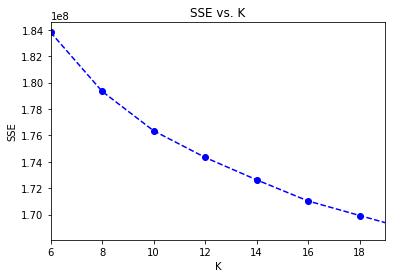

In [46]:
# Investigate the change in within-cluster distance across number of clusters.

# Plot the score against k
plt.plot(ks, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');
plt.xticks(ks);
plt.xlim(6,19)

After choosing the value 19 for k, run KMeans again:

In [24]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters=19)
model = kmeans.fit(X_pca)
preds = model.predict(X_pca)

# Do the same for customers
preds_c = kmeans.predict(Xc_pca)

Save data needed to perform the comparison later in a pickle:

In [25]:
# save preds_c in a pickle
pickle.dump(preds, open("preds.pickle", "wb"))
pickle.dump(preds_c, open("preds_c.pickle", "wb"))

In [26]:
X_pca.shape[0]

733939

In [27]:
Xc_pca.shape[0]

132345

## Comparing customers and general population

In [ ]:
#preds = pickle.load(open("preds.pickle", "rb"))
#preds_c = pickle.load(open("preds_c.pickle", "rb"))

In [28]:
# Calculate proportions of persons in each cluster
n = X_pca.shape[0] # 733939
nc = Xc_pca.shape[0] #132345


proportions_general = pd.Series(preds).value_counts().sort_index()/n
proportions_cust = pd.Series(preds_c).value_counts().sort_index()/nc

df = pd.DataFrame({'cluster': proportions_general.index,
                  'p_general': proportions_general.values,
                  'p_customer':proportions_cust.values})

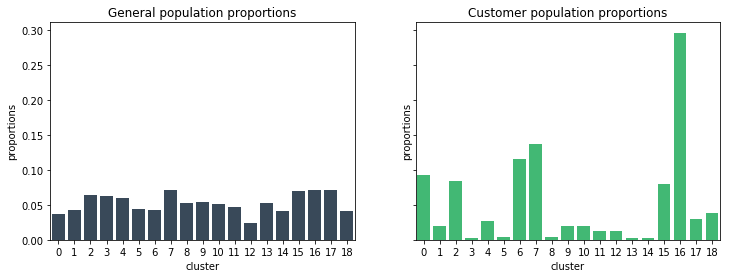

In [29]:
# Plot proportions 

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12,4), sharey=True)
g = sns.barplot(x="cluster", y="p_general", data=df,
                color='#34495e', ax=ax1);
g.set_title('General population proportions');
g.set_ylabel('proportions');

g2 = sns.barplot(x="cluster", y="p_customer", data=df,
                color='#2ecc71', ax=ax2);
g2.set_title('Customer population proportions');
g2.set_ylabel('proportions');

In [30]:
def plot_scaled_comparison(df_sample, kmeans, cluster):
    '''
    visualize weights of features after apply pca.inverse_transform on cluster centroid
    '''
    centroid = kmeans.cluster_centers_[cluster]
    
    X = pd.DataFrame.from_dict(
        dict(zip(df_sample.columns, pca.inverse_transform(centroid))),orient='index').rename(columns={0: 'feature_values'}).sort_values('feature_values', ascending=False)
    
    X['feature_values_abs'] = abs(X['feature_values'])
    pd.concat((X['feature_values'][:10], X['feature_values'][-10:]), axis=0).plot(kind='barh', color="#2ecc71");

In [31]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

clusters_over = {}

for i in range(19):
    
    pc =  df['p_customer'][i]
    pg = df['p_general'][i]
    
    if pc > pg:
        clusters_over[i] = abs(pc-pg)*100 # percentage diff

clusters_over

{0: 5.6056849171725762,
 2: 1.9608370475206276,
 6: 7.3142928622112331,
 7: 6.4508668959487148,
 15: 1.0141141839509564,
 16: 22.425519714232582}

#### Interpretation: Cluster 16

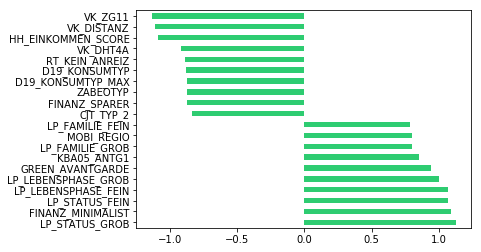

In [32]:
plot_scaled_comparison(customers, kmeans, 16)

This cluster represents families, with high income, house owners, high social status, low mobility, low energy consumption and environment is important to them. Tendency to spare money and high financial interest.
 

#### Interpretation: Cluster 6

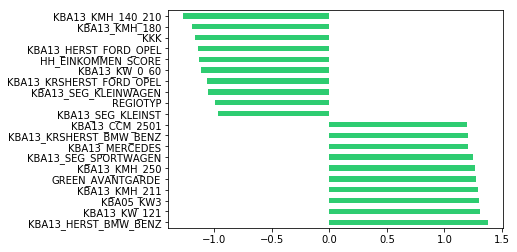

In [34]:
plot_scaled_comparison(customers, kmeans, 6)

This cluster is related to sportscars (specially BMW and Mercedes) in upper class neighbourhoods, with high income and high purchasing power.

#### Interpretation: Cluster 7

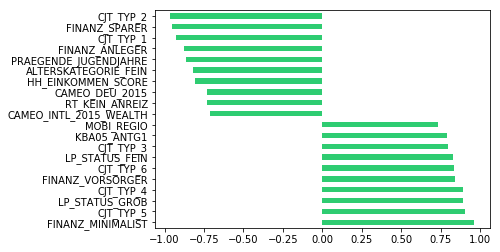

In [35]:
plot_scaled_comparison(customers, kmeans, 7)

This cluster represents younger people, houseowners, low mobility, high financial interest,living in regions with a high share of small families homes. Regarding the financial type, tendency to spare money.

#### Interpretation: underrepresented clusters

In [36]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

clusters_under = {}

for i in range(19):
    
    pc =  df['p_customer'][i]
    pg = df['p_general'][i]
    
    if pg > pc:
        clusters_under[i] = abs(pg-pc)*100 # percentage diff
        
clusters_under

{1: 2.2431547097860927,
 3: 5.9274323891967651,
 4: 3.3871219407850663,
 5: 3.9864717336366531,
 8: 4.7457212897297003,
 9: 3.463906216451667,
 10: 3.1334706524673774,
 11: 3.4056526223404262,
 12: 1.1405502948012365,
 13: 5.0377772085251991,
 14: 3.8431518114143226,
 17: 4.1018441785494835,
 18: 0.35506057335269875}

#### Interpretation: Cluster 17

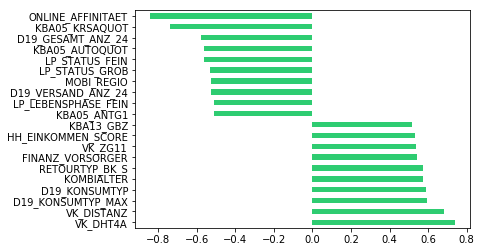

In [41]:
plot_scaled_comparison(customers, kmeans, 17)

This cluster represents people iwth low online presence, in regions with below of the average share of cars. Consumer type: informed, low-returner, average/lower income

#### Interpretation: Cluster 3

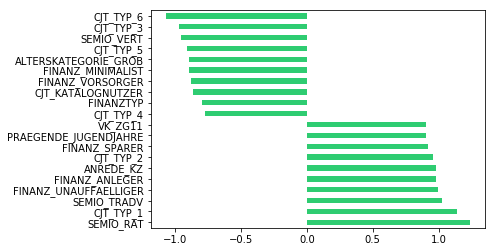

In [39]:
plot_scaled_comparison(customers, kmeans, 3)

Personality type: low affinity to rational minded, dominant minded or fightful
Gender: younger women (<45)
Financial: spend money, low investing, low financial interest, 

#### Interpretation: Cluster 8

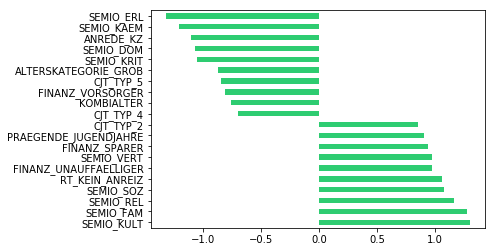

In [40]:
plot_scaled_comparison(customers, kmeans, 8)

This cluster represents people who live in region with high share of cars built between 2000 and 2003, have lower income and low financial interest.

This cluster represents people with low affinity to cultural minded, familiar minded, religious, social minded and that
are not money savers.
    

## Part 2: Supervised Learning Model

After finding which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.utils import resample, shuffle
from collections import OrderedDict
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, precision_score,recall_score
from sklearn.model_selection import StratifiedKFold

In [30]:
def clean_data_models(dataframe, azdias_attr_nan):
    x = replace_nan(dataframe, azdias_attr_nan)
    x = remove_outliers(x)
    x = preprocessing_categorical(x)
    return x

In [32]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
azdias_attr_nan = pickle.load(open("azdias_attr_nan.pickle", "rb"))

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [33]:
data = clean_data_models(mailout_train, azdias_attr_nan)
data.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
0,1763,1.0,8.0,8.0,15.0,0.0,0.0,1.0,13.0,0.0,...,1.0,6.0,9.0,3.0,3,0,2,4,3.0,4.0
1,1771,4.0,13.0,13.0,1.0,0.0,0.0,2.0,1.0,0.0,...,1.0,4.0,9.0,7.0,1,0,2,3,3.0,2.0
2,1776,1.0,9.0,7.0,0.0,NaN,0.0,0.0,1.0,0.0,...,2.0,NaN,9.0,2.0,3,0,1,4,1.0,4.0
3,1460,1.0,6.0,6.0,4.0,0.0,0.0,2.0,4.0,0.0,...,11.0,6.0,9.0,1.0,3,0,2,4,1.0,4.0
4,1783,1.0,9.0,9.0,53.0,0.0,0.0,1.0,44.0,0.0,...,1.0,6.0,9.0,3.0,3,0,1,3,4.0,1.0


In [35]:
def map_cluster_16(row):
    if row['HH_EINKOMMEN_SCORE'] <= 3 and row['GREEN_AVANTGARDE']==1 and (row['LP_STATUS_FEIN']>5) \
    and row['FINANZ_MINIMALIST']>=3:
            return 1
    else:
        return 0 

In [36]:
data['CLUSTER_16'] = data.apply(lambda x: map_cluster_16(x), axis=1)

**There is a class imbalance in this dataset, only 1% became customers. 2 approaches from here:**
- try a method robust to class imbalance
- resample the dataset 

In [37]:
def downsample(df, downsampling_factor=20):
    # Calculates how many samples we resample from the majority class
    # downsampling_factor = 20
    n_samples = round(df.shape[0]/downsampling_factor)

    # Join together # separate classes
    df_majority = df[df['RESPONSE'] == 0]
    df_minority = df[df['RESPONSE'] == 1]
    # downsample without replacement majority class
    df_majority_downsampled = resample(df_majority, replace=False, n_samples=n_samples, random_state=0)  

    # save the index to use when perform the upweight of the samples
    resampled_index = df_majority_downsampled.index

    # combine minority class with downsampled majority class
    df_downsampled = pd.concat([df_majority_downsampled, df_minority])

    # shuffle dataframe",
    df_downsampled = shuffle(df_downsampled)

    # take a look into proportion after resampling",
    df_majority = df_downsampled[df_downsampled['RESPONSE']==0]
    df_minority = df_downsampled[df_downsampled['RESPONSE']==1]
    print('Proportion of minority class after downsampling: {:2.2f}%'.format(100*df_minority.shape[0]/df_downsampled.shape[0]))
    print('Proportion of majority class after downsampling: {:2.2f}%'.format(100*df_majority.shape[0]/df_downsampled.shape[0]))
    
    return df_downsampled
 

In [38]:
df_downsampled = downsample(data, 20)

Proportion of minority class after downsampling: 19.85%
Proportion of majority class after downsampling: 80.15%


#### Impute NaN and Scale data

In [41]:
def impute_and_scale(df):
    imputer = Imputer(missing_values=np.nan, strategy='most_frequent', axis=0)
    X_mailout = imputer.fit_transform(df)
    X_mailout = pd.DataFrame(X_mailout)
    X_mailout.columns = df.columns

    scaler = StandardScaler()
    X_scaled_mailout = scaler.fit_transform(X_mailout)
    X_scaled_mailout = pd.DataFrame(X_scaled_mailout)
    X_scaled_mailout.columns = df.columns
    
    return X_scaled_mailout

In [42]:
X_scaled = impute_and_scale(df_downsampled)

#### Separate train and test data

In [86]:
# Separate training and test data
X = X_scaled.drop(columns=['RESPONSE'])
y = df_downsampled['RESPONSE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Metric: ROC_AUC 

In [87]:
def classifier_roc(clf, X, y, parameters={}):
    
    grid = GridSearchCV(estimator=clf, param_grid=parameters, scoring='roc_auc', cv=5)
    grid.fit(X, y)
    
    print("Best score:", grid.best_score_)
    
    return grid.best_estimator_

### Train models

In [ ]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X, y);

- **Adaboost**

In [88]:
ada = AdaBoostClassifier(random_state=0)
ada.fit(X_train, y_train)
ada_preds = ada.predict(X_test)

In [89]:
print(classifier_roc(ada, X_train, y_train))

Best score: 0.74285310084
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=0)


In [90]:
print(classification_report(y_test, ada_preds))

             precision    recall  f1-score   support

          0       0.83      0.91      0.87       637
          1       0.46      0.30      0.36       167

avg / total       0.75      0.78      0.76       804



In [91]:
print(confusion_matrix(y_test, ada_preds))   #  vertical: true labels / horizontal: predicted

[[578  59]
 [117  50]]


- **XGBoost**

In [92]:
gb = GradientBoostingClassifier(random_state=0)
gb.fit(X_train, y_train)
gb_preds = gb.predict(X_test)
print(classification_report(y_test, gb_preds))

             precision    recall  f1-score   support

          0       0.81      0.96      0.88       637
          1       0.49      0.14      0.21       167

avg / total       0.74      0.79      0.74       804



In [93]:
print(classifier_roc(gb, X_train, y_train))

Best score: 0.760570371966
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False)


In [94]:
print(confusion_matrix(y_test, gb_preds))   #  vertical: true labels / horizontal: predicted

[[613  24]
 [144  23]]


### Tuning final model

- XGBoost:

In [117]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
data = clean_data_models(mailout_train, azdias_attr_nan)
X_scaled = impute_and_scale(data)
X = X_scaled.drop(columns=['RESPONSE'])
y = data['RESPONSE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [118]:
mailout_train.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
0,1763,1.0,8.0,8.0,15.0,0.0,0.0,1.0,13.0,0.0,...,1.0,6.0,9.0,3.0,3,0,2,4,3.0,4.0
1,1771,4.0,13.0,13.0,1.0,0.0,0.0,2.0,1.0,0.0,...,1.0,4.0,9.0,7.0,1,0,2,3,3.0,2.0
2,1776,1.0,9.0,7.0,0.0,NaN,0.0,0.0,1.0,0.0,...,2.0,NaN,9.0,2.0,3,0,1,4,1.0,4.0
3,1460,1.0,6.0,6.0,4.0,0.0,0.0,2.0,4.0,0.0,...,11.0,6.0,9.0,1.0,3,0,2,4,1.0,4.0
4,1783,1.0,9.0,9.0,53.0,0.0,0.0,1.0,44.0,0.0,...,1.0,6.0,9.0,3.0,3,0,1,3,4.0,1.0


In [119]:
%%time
parameters = {
    'learning_rate': [0.1, 1],
    'max_depth': [3],
    'n_estimators': [100]
}

grid = GridSearchCV(estimator=GradientBoostingClassifier(), param_grid=parameters, scoring='roc_auc', cv=5)
grid.fit(X_train, y_train)
print(grid.best_score_)
print(grid.best_estimator_)

0.742780720767
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
CPU times: user 4min 51s, sys: 35.8 ms, total: 4min 51s
Wall time: 4min 53s


In [120]:
best_gb = grid.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

- Adaboost:

In [106]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
data = clean_data_models(mailout_train, azdias_attr_nan)
df = data.drop(columns=drop_feat)
df_downsampled = downsample(df, 20)
X_scaled = impute_and_scale(df_downsampled)
X = X_scaled.drop(columns=['RESPONSE'])
y = df_downsampled['RESPONSE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Proportion of minority class after downsampling: 19.85%
Proportion of majority class after downsampling: 80.15%


In [108]:
%%time
param_grid = {
    'learning_rate': [0.1, 1.0],
    'n_estimators': [100, 200, 300]
}

grid = GridSearchCV(estimator=AdaBoostClassifier(), param_grid=param_grid, scoring='roc_auc', cv=5)
grid.fit(X_train, y_train)
print(grid.best_score_)
print(grid.best_estimator_)

0.759399584258
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=100, random_state=None)
CPU times: user 56.4 s, sys: 0 ns, total: 56.4 s
Wall time: 56.6 s


In [109]:
best_ada = grid.best_estimator_

0.758228178972
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=300, random_state=None)
CPU times: user 57.6 s, sys: 8.04 ms, total: 57.6 s

**Model validation**

In [81]:
# based on https://www.kaggle.com/ynouri/random-forest-k-fold-cross-validation

def plot_roc_curve(fprs, tprs):
    '''
    Plot ROC from array of true positive and false positive.
    '''
    true_pos_interp = []
    computed_auc = []
    mean_false_positive = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(6,5))
    
    # for each KFold compute scores
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        true_pos_interp.append(np.interp(mean_false_positive, fpr, tpr))
        true_pos_interp[-1][0] = 0.0
        current_roc_auc = auc(fpr, tpr)
        computed_auc.append(current_roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='Fold %d (AUC = %0.2f)' % (i, current_roc_auc))
    
    # Plot the mean ROC
    mean_true_positive = np.mean(true_pos_interp, axis=0)
    mean_true_positive[-1] = 1.0
    mean_auc = auc(mean_false_positive, mean_true_positive)
    std_auc = np.std(computed_auc)
    ax.plot(mean_false_positive, mean_true_positive, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    
    # Plot the std around the mean ROC curve
    std_tpr = np.std(true_pos_interp, axis=0)
    tprs_upper = np.minimum(mean_true_positive + std_tpr, 1)
    tprs_lower = np.maximum(mean_true_positive - std_tpr, 0)
    ax.fill_between(mean_false_positive, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')
    

    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC curve for Adaboost classifier')
    ax.legend(loc="lower right")
    plt.show()

def compute_roc_auc(index):
    y_preds = clf.predict_proba(X.iloc[index])[:,1]
    fpr, tpr, _ = roc_curve(y.iloc[index], y_preds)
    current_auc_score = auc(fpr, tpr)
    return fpr, tpr, current_auc_score

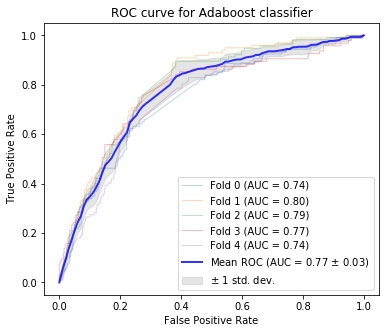

,Train score,Test score
0,0.820952,0.740171
1,0.807807,0.802221
2,0.809900,0.793556
3,0.808711,0.766726
4,0.822155,0.738592


In [83]:
# separate target variable
X = X_scaled.drop(columns=['RESPONSE'])
y = df_downsampled['RESPONSE']

# initialize model to be validated
clf = AdaBoostClassifier(learning_rate=0.1, n_estimators=100)

# use KFold to validate model
cv = KFold(n_splits=5, random_state=0, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
false_positives, true_positives, scores = [], [], []
    
for (train, test), i in zip(cv.split(X, y), range(5)):
    # fit classifier
    clf.fit(X.iloc[train], y.iloc[train])
    
    # compute score for this fold for training and test data
    _, _, auc_score_train = compute_roc_auc(train)
    fpr, tpr, auc_score = compute_roc_auc(test)
    
    # save results
    scores.append((auc_score_train, auc_score))
    false_positives.append(fpr)
    true_positives.append(tpr)

plot_roc_curve(false_positives, true_positives);
pd.DataFrame(scores, columns=['Train score', 'Test score'])

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [110]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [111]:
data = clean_data_models(mailout_test, azdias_attr_nan)

In [112]:
data = data.drop(columns=drop_feat)

In [113]:
X_scaled = impute_and_scale(data)

In [114]:
preds = best_ada.predict_proba(X_scaled)

In [115]:
output = pd.DataFrame({'LNR':data.LNR, 'RESPONSE': preds[:,1]})

In [116]:
output.to_csv('output.csv', index = False)